# Analisi Dati – NSL-KDD Dataset

Questa sezione documenta la fase di **analisi esplorativa dei dati (EDA)** sul dataset NSL-KDD, con l’obiettivo di comprenderne la struttura, individuare criticità e predisporre i dati per l’addestramento di modelli di *Machine Learning* per un **Intrusion Detection System (IDS)**.

##  Obiettivi dell'analisi
1. Comprendere le caratteristiche strutturali del dataset.
2. Evidenziare squilibri, outlier e correlazioni tra variabili.
3. Applicare trasformazioni di preprocessing per ottenere un dataset numerico, coerente e pronto per il training.


## 1 – Caricamento del dataset
Il dataset **NSL-KDD** è una versione migliorata del KDD’99, composto da 41 feature di tipo numerico e categorico, più due colonne: `label` (classe) e `difficulty` (indice di complessità).

In [16]:
import pandas as pd

# Definizione delle colonne ufficiali
columns = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files",
    "num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
    "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
    "dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
    "dst_host_srv_rerror_rate","label","difficulty"
]

train = pd.read_csv("data/nsl-kdd/KDDTrain+.TXT", names=columns)
test = pd.read_csv("data/nsl-kdd/KDDTest+.TXT", names=columns)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (125973, 43)
Test shape: (22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


## 2 – Distribuzione delle classi (multiclasse)
Si analizza la colonna `label`, che distingue traffico normale da diverse tipologie di attacco.

Ci si aspetta una distribuzione **fortemente sbilanciata**, con poche classi molto frequenti (*neptune*, *smurf*) e molte classi rare (*spy*, *perl*).

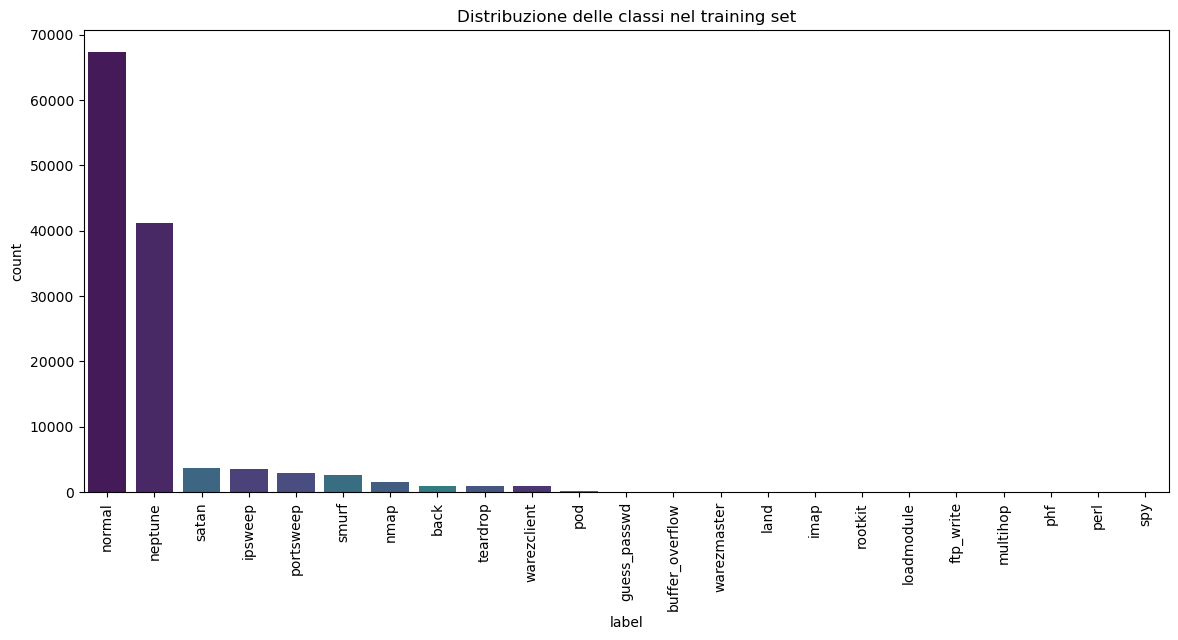

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.countplot(
    data=train,
    x="label",
    order=train["label"].value_counts().index,
    hue="label",       
    dodge=False,       
    legend=False,      
    palette="viridis"  
)
plt.xticks(rotation=90)
plt.title("Distribuzione delle classi nel training set")
plt.show()


📌 **Interpretazione:**
- Alcune classi hanno migliaia di istanze, altre pochissime.
- Questo squilibrio è tipico nei problemi di sicurezza informatica (*long tail distribution*).
- Un modello addestrato senza correzioni rischierebbe di ignorare le classi minoritarie.

## 3 – Etichetta binaria (Normal vs Attack)
Per semplificare il problema e allinearsi all’obiettivo primario di un IDS, si definirà una colonna `binary_label`: 0 = normal, 1 = attack.

C:\Users\15-DW1087\AppData\Local\Temp\ipykernel_22364\1145025877.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x="binary_label", palette="Set2")


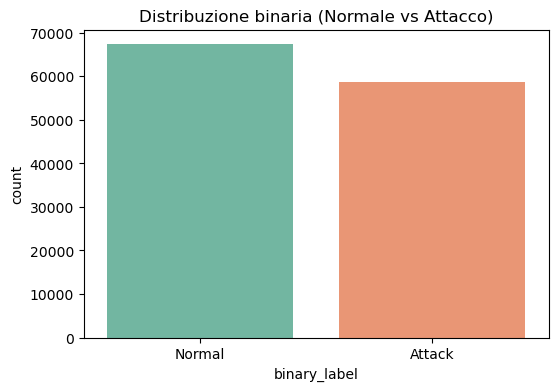

binary_label
0    53.458281
1    46.541719
Name: proportion, dtype: float64


In [18]:
train["binary_label"] = train["label"].apply(lambda x: 0 if x == "normal" else 1)
test["binary_label"] = test["label"].apply(lambda x: 0 if x == "normal" else 1)

plt.figure(figsize=(6,4))
sns.countplot(data=train, x="binary_label", palette="Set2")
plt.title("Distribuzione binaria (Normale vs Attacco)")
plt.xticks([0,1],["Normal","Attack"])
plt.show()

print(train["binary_label"].value_counts(normalize=True) * 100)

## 4 – Statistiche descrittive delle variabili numeriche
Si esaminano alcune variabili chiave (`duration`, `src_bytes`, `dst_bytes`, `count`, `srv_count`).

           duration     src_bytes     dst_bytes          count      srv_count
count  125973.00000  1.259730e+05  1.259730e+05  125973.000000  125973.000000
mean      287.14465  4.556674e+04  1.977911e+04      84.107555      27.737888
std      2604.51531  5.870331e+06  4.021269e+06     114.508607      72.635840
min         0.00000  0.000000e+00  0.000000e+00       0.000000       0.000000
25%         0.00000  0.000000e+00  0.000000e+00       2.000000       2.000000
50%         0.00000  4.400000e+01  0.000000e+00      14.000000       8.000000
75%         0.00000  2.760000e+02  5.160000e+02     143.000000      18.000000
max     42908.00000  1.379964e+09  1.309937e+09     511.000000     511.000000


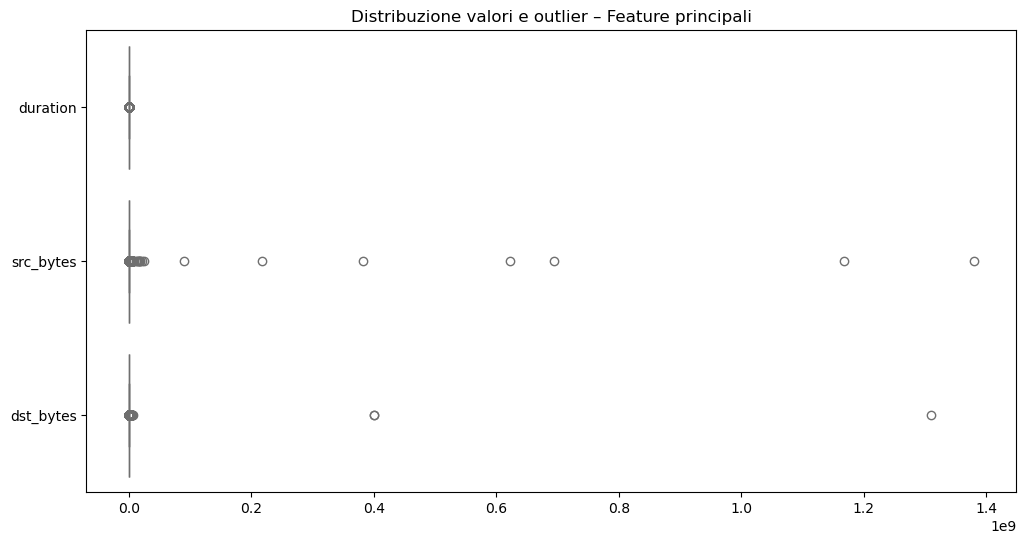

In [19]:
print(train[["duration","src_bytes","dst_bytes","count","srv_count"]].describe())

plt.figure(figsize=(12,6))
sns.boxplot(data=train[["duration","src_bytes","dst_bytes"]], orient="h", palette="pastel")
plt.title("Distribuzione valori e outlier – Feature principali")
plt.show()

 **Interpretazione:**
- Le feature presentano distribuzioni asimmetriche e numerosi outlier; in questo caso non sono rumore ma spesso segnali di traffico anomalo, di conseguenza risulta importante sia preservare queste informazioni che ridurre le distorsioni tramite scaling.

## 5 – Correlazione tra variabili numeriche
Si analizzano le correlazioni per identificare feature ridondanti.

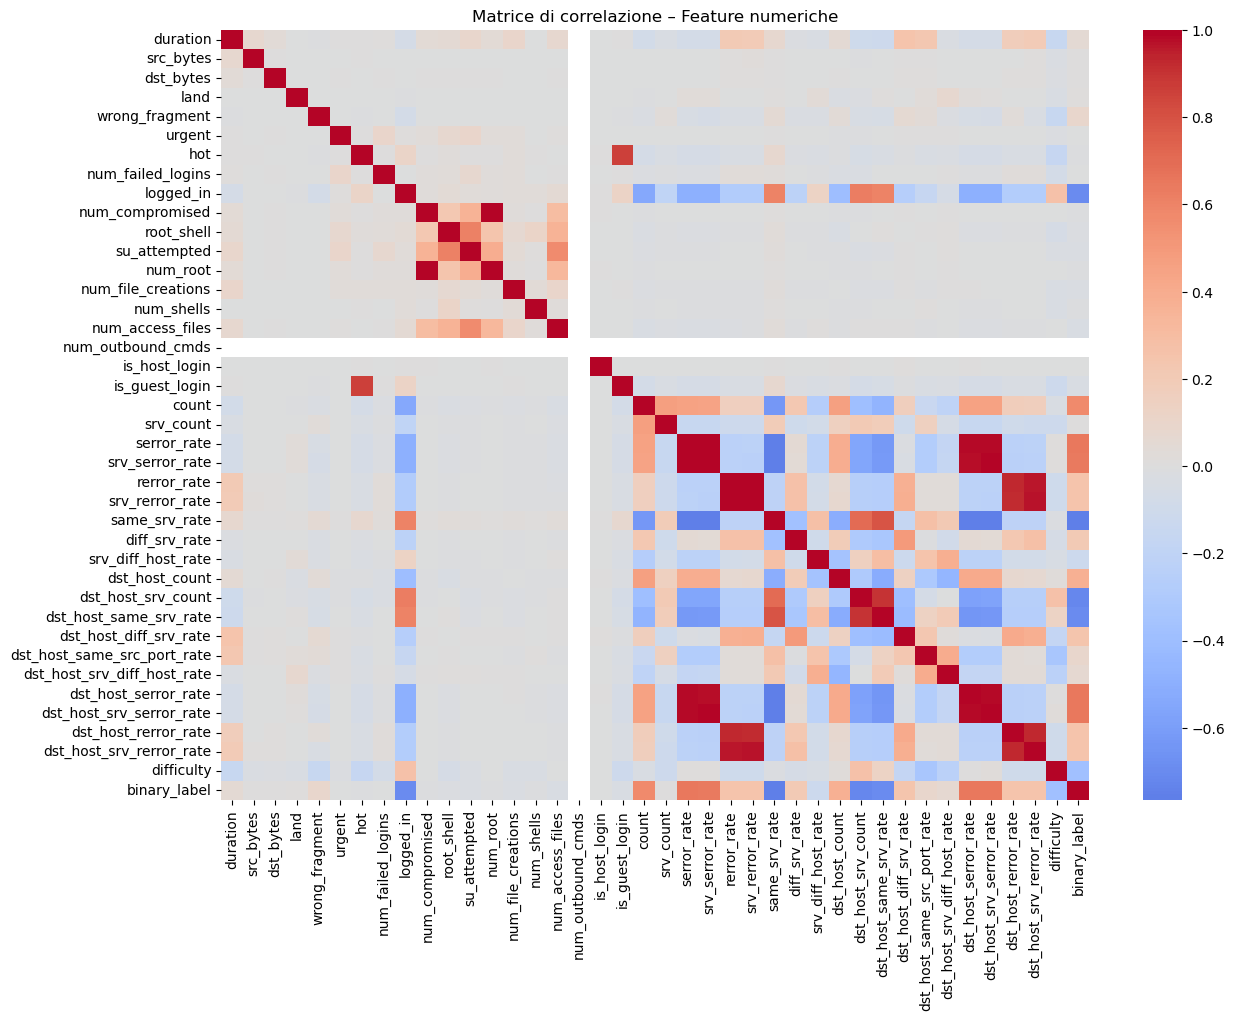

In [20]:
corr_matrix = train.corr(numeric_only=True)

plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Matrice di correlazione – Feature numeriche")
plt.show()

 **Interpretazione:**
- Coppie di feature (es. `serror_rate` e `srv_serror_rate`) risultano fortemente correlate.
- Questo suggerisce la presenza di ridondanza, che potrà essere gestita con feature selection o riduzione dimensionale (PCA).

## Feature Selection con Random Forest

Per ridurre la ridondanza e identificare le variabili più rilevanti ai fini della classificazione, è stata applicata una **Feature Selection basata su Random Forest**.  
Questa tecnica sfrutta l’importanza delle variabili (`feature importance`), calcolata come riduzione media dell’impurità ottenuta quando una feature viene utilizzata per effettuare split all’interno degli alberi.

### Risultati principali
- Le feature **più importanti** risultano essere `src_bytes`, `dst_bytes`, `same_srv_rate`, `dst_host_srv_count`, `dst_host_same_srv_rate` e `flag`.  
  Queste variabili descrivono la quantità di traffico scambiato e le caratteristiche delle connessioni TCP/servizi, elementi chiave per individuare anomalie.  
- Alcune feature, come `num_outbound_cmds`, `is_host_login` e `su_attempted`, hanno importanza trascurabile (< 0.001), indicando che possono essere eliminate senza perdita di accuratezza.  
- La **curva cumulativa** mostra che le prime ~15–20 feature spiegano già oltre il **70–80% dell’importanza totale**, suggerendo che un sottoinsieme ristretto di variabili è sufficiente a mantenere buone performance del modello.  

### Conclusioni
L’analisi conferma che il dataset contiene un numero significativo di variabili ridondanti o poco informative.  
La selezione delle feature più rilevanti consente di:
- semplificare il modello,
- ridurre i tempi di training,
- aumentare la robustezza e l’interpretabilità del sistema di IDS.

,feature,importance
4,src_bytes,0.1968
5,dst_bytes,0.1070
28,same_srv_rate,0.0778
32,dst_host_srv_count,0.0690
33,dst_host_same_srv_rate,0.0690
3,flag,0.0654
11,logged_in,0.0537
29,diff_srv_rate,0.0355
1,protocol_type,0.0317
22,count,0.0296



Feature con importanza trascurabile (< 0.001):


,feature,importance
15,num_root,0.0003
10,num_failed_logins,0.0002
16,num_file_creations,0.0002
13,root_shell,0.0001
18,num_access_files,0.0001
17,num_shells,0.0001
6,land,0.0000
8,urgent,0.0000
14,su_attempted,0.0000
20,is_host_login,0.0000


C:\Users\15-DW1087\AppData\Local\Temp\ipykernel_22364\1358014441.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(20), x="importance", y="feature", palette="viridis")


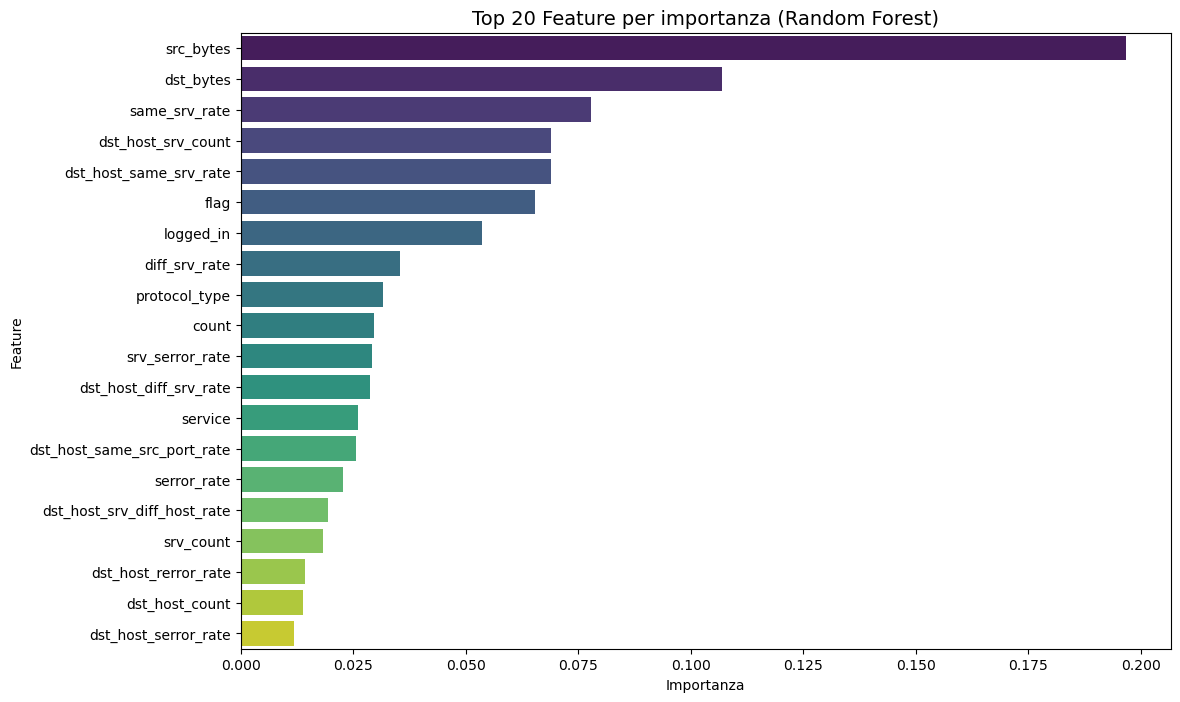

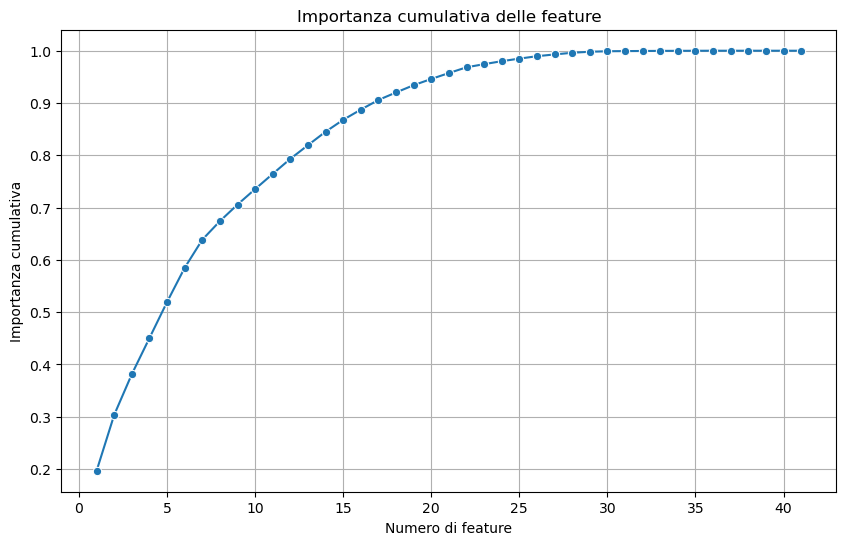

In [ ]:



import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier


df = train.copy()

# Etichetta binaria
df["binary_label"] = df["label"].apply(lambda x: 0 if x == "normal" else 1)

# Encoding variabili categoriche
encoder = LabelEncoder()
for col in ["protocol_type", "service", "flag"]:
    df[col] = encoder.fit_transform(df[col])

# X (feature) e y (target)
X = df.drop(columns=["label", "difficulty", "binary_label"])
y = df["binary_label"]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Training Random Forest per calcolare importanza delle feature
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf.fit(X_scaled, y)

importances = rf.feature_importances_
feature_names = X.columns

feature_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Arrotondamento dei valori
feature_importance["importance"] = feature_importance["importance"].round(4)

# 3. Tabella completa ordinata
pd.set_option("display.max_rows", None)
display(feature_importance)

# 4. Feature poco rilevanti (importanza < 0.001)
low_importance = feature_importance[feature_importance["importance"] < 0.001]
print("\nFeature con importanza trascurabile (< 0.001):")
display(low_importance)

# 5. Visualizzazione Top 20
plt.figure(figsize=(12,8))
sns.barplot(data=feature_importance.head(20), x="importance", y="feature", palette="viridis")
plt.title("Top 20 Feature per importanza (Random Forest)", fontsize=14)
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.show()

# 6. Curva cumulativa
feature_importance["cumulative"] = feature_importance["importance"].cumsum()
plt.figure(figsize=(10,6))
sns.lineplot(x=range(1, len(feature_importance)+1),
    y="cumulative",
    data=feature_importance, marker="o")
plt.title("Importanza cumulativa delle feature")
plt.xlabel("Numero di feature")
plt.ylabel("Importanza cumulativa")
plt.grid(True)
plt.show()


## 6 – Preprocessing dataset
Si applicano le trasformazioni necessarie per preparare i dati al training:
- Encoding delle variabili categoriche (`protocol_type`, `service`, `flag`).
- Conversione target binario (0 = normal, 1 = attack).
- Standardizzazione delle feature numeriche.

In [22]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = train.copy()

encoder = LabelEncoder()
for col in ["protocol_type", "service", "flag"]:
    df[col] = encoder.fit_transform(df[col])

y = df["binary_label"]
X = df.drop(columns=["label","difficulty","binary_label"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape features:", X_scaled.shape)
print("Shape target:", y.shape)

Shape features: (125973, 41)
Shape target: (125973,)


# Conclusioni 
L’analisi condotta sul dataset NSL-KDD ha evidenziato:
1. **Forte sbilanciamento delle classi**, da gestire con metriche adeguate e tecniche di riequilibrio.
2. **Presenza di outlier** informativi, da preservare ma normalizzare.
3. **Ridondanza tra feature**: possibile ottimizzazione con feature selection o PCA.
4. **Preprocessing coerente**: encoding e scaling corretti per algoritmi ML.

 Il dataset risulta pronto per la fase successiva di addestramento e valutazione di modelli di Machine Learning per la realizzazione di un sistema IDS per scopo didattico o di ricerca.
